In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from scipy.interpolate import CubicSpline as cs

hbar = 6.582e-22

Create five arrays: ``fe``, ``e``, ``T``, ``a``, and ``t``.
- ``fe`` and ``e`` are 2-dimensional arrays for the distribution function and epsilon values, respectively. Their dimensions should be N_steps x N_eps (number of saved time steps by number of epsilon values).
- ``T``, ``a``, and ``t`` are arrays of length N_steps and stores the values of Temperature, scale factor, and time (in seconds). Use ``hbar`` to convert between inverse MeV and seconds.

In [2]:
data = np.load("mass-300-life-1.004.npz", allow_pickle=True)
fe = data['fe']
e = data['e']
T = data['T']
a = data['a']
t = data['t'] * hbar

In [3]:
a_std = np.load("std_a.npy")
T_std = np.load("std_T.npy")
cs_Tcm = cs(np.flip(T_std),np.flip(1/a_std))

In [4]:
T_list = []
for i in range(len(T)):
    if T[i] >= 10:
        T_list.append("{:.2f}  MeV".format(T[i]))
    elif T[i] >= 1:
        T_list.append(" {:.2f}  MeV".format(T[i]))
    else:
        T_list.append(" {:.3f} MeV".format(T[i]))

time_list = []
for time in t:
    if time < 0.1:
        time_list.append("{:6.1f}  ms".format(time*1000))
    elif time < 1000:
        time_list.append(" {:6.2f}  s".format(time))
    else:
        time_list.append("{:6.1f}  ks".format(time/1000))

MovieWriter ffmpeg unavailable; using Pillow instead.


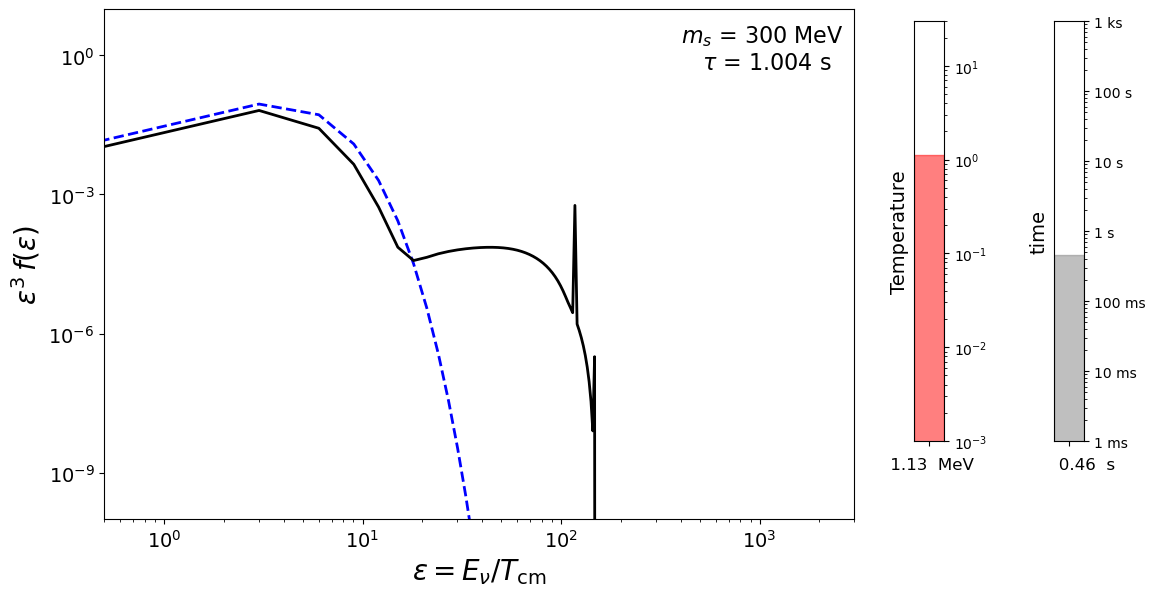

In [6]:
fig = plt.figure(figsize=(12,6))
ax = plt.axes([1.3/12,0.12,7.5/12,0.85])
e_thermal, = ax.loglog([], [], linewidth=2, linestyle='--',color='b')
nu, = ax.loglog([], [], linewidth=2, color='k')
ax.set_ylim([1e-10,10])
ax.set_yticks([1e-9,1e-6,1e-3,1e0])
ax.set_xlim([0.5,3000])
ax.set_xticks([1e0,1e1,1e2,1e3])
ax.set_xlabel(r"$\epsilon = E_\nu / T_{\rm cm}$",fontsize=20)
ax.set_ylabel(r"$\epsilon^3 \, f(\epsilon)$",fontsize=20)
#ax.set_title("{} MeV, {:.3} s decay lifetime".format(ms,ts))
ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=14)

ax.text(4e2, 0.5, r"$m_s$ = 300 MeV" + '\n' + r"   $\tau$ = 1.004 s", fontsize=16)

temp_bar = plt.axes([9.4/12, 0.25, 0.3/12, 0.7])
temp_bar.set_ylim([1e-3,30])
temp_bar.set_yticks([1e-3, 1e-2, 1e-1, 1, 10])
temp_bar.set_yscale('log')
temp_bar.yaxis.tick_right()
temp_bar.set_xlim([-0.5,0.5])
temp_bar.set_xticks([0])
temp_bar.set_xticklabels([''])
T_val = temp_bar.text(0,5e-4,"",ha='center', fontsize=12)
temp_bar.set_ylabel("Temperature",fontsize=14)
T_bar = temp_bar.axhspan(0, 15, color='r', alpha=0.5)
Temp_mat = np.copy(T_bar.xy)

time_bar = plt.axes([10.8/12, 0.25, 0.3/12, 0.7])
time_bar.set_ylim([1e-3, 1e3])
time_bar.set_yscale('log')
time_bar.yaxis.tick_right()
time_bar.set_yticks([1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3])
time_bar.set_yticklabels(['1 ms', '10 ms', '100 ms', '1 s', '10 s', '100 s', '1 ks'])
time_bar.set_ylabel("time", fontsize=14)
time_bar.set_xlim([-0.5,0.5])
time_bar.set_xticks([0])
time_bar.set_xticklabels([''])
time_val = temp_bar.text(5, 5e-4, time_list[0],ha='center',fontsize=12) 
t_rect = time_bar.axhspan(0, t[0], color='0.50', alpha=0.5)

time_mat = np.copy(t_rect.xy)

def init():
    e_thermal.set_data([], [])
    nu.set_data([], [])

    T_val.set_text(T_list[0])
    time_val.set_text(time_list[0])
    return e_thermal, nu, T_val, T_bar, time_val, t_rect

def animate(i):
    eps = e[i]
    fv = fe[i]
    
    e_thermal.set_data(eps, eps**3 / (np.exp(eps / a[i] /  cs_Tcm(T[i])) +1) / (2 * np.pi**2))
    nu.set_data(eps, eps**3 * fv / (2 * np.pi**2))
    T_val.set_text(T_list[i])
    Temp_mat[1:3,1] = T[i]
    T_bar.set_xy(Temp_mat)
    
    time_val.set_text(time_list[i])
    time_mat[1:3,1] = t[i]
    t_rect.set_xy(time_mat)
    return e_thermal, nu, T_val, T_bar, time_val, t_rect

anim = animation.FuncAnimation(fig, animate, init_func = init, frames = len(T), interval = 33, blit=True)
anim.save("f_temp.gif")
